# Print Temperature chamber data

In [74]:
import pandas as pd
import matplotlib.pyplot as plt


In [75]:
# Update the File paths here
raw_data_file_path = "measurement_log_20250401_130508.csv"  # add raw data file path here
tmp_chamber_data_file_path = "01 april.csv" # enter the path for the csv file from temp chamber

In [76]:
df_tmp_chmber = pd.read_csv(tmp_chamber_data_file_path)
df_tmp_chmber['Date/Time'] = pd.to_datetime(df_tmp_chmber['Date/Time'])
df_tmp_chmber.head()


,Date/Time,Ideal,Actual,CV2_SP,CV2_AV,CV3_SP,CV3_AV,Fan _speed,Temp_shift,Temp_Diff,MV1_AV,MV2_AV,MV3_AV,MV4_AV,MV5_AV,MV6_AV
0,2025-04-01 13:04:25,22.591,22.855,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2025-04-01 13:05:25,12.795,22.790,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2025-04-01 13:06:25,3.055,22.465,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2025-04-01 13:07:25,-6.730,13.085,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2025-04-01 13:08:25,-16.499,-0.630,0,0,0,0,0,0,0,0,0,0,0,0,0


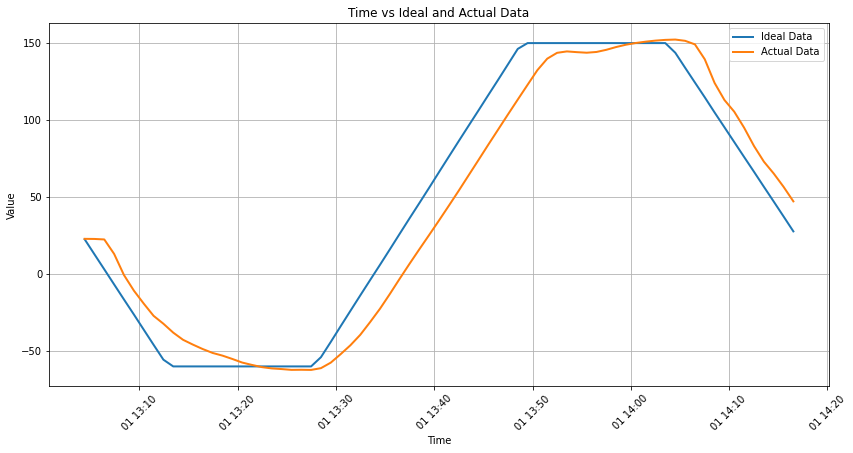

In [77]:
# Plotting Ideal vs Actual data
plt.figure(figsize=(12, 6))
plt.plot(df_tmp_chmber['Date/Time'], df_tmp_chmber['Ideal'], label='Ideal Data', linewidth=2)
plt.plot(df_tmp_chmber['Date/Time'], df_tmp_chmber['Actual'], label='Actual Data', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time vs Ideal and Actual Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


# Print RAW data graph for visualization

In [78]:
# Load the CSV file
df_raw_data = pd.read_csv(raw_data_file_path)
df_raw_data['timestamp'] = pd.to_datetime(df_raw_data['timestamp'])
df_raw_data.head()


,step,timestamp,encoder,SIN_P,COS_P,SIN_N,COS_N,cycle
0,0,2025-04-01 13:05:11,0,16766,10981,9637,15405,1
1,1,2025-04-01 13:05:11,642,16925,11314,9313,14936,1
2,2,2025-04-01 13:05:12,614,17116,11697,9266,14688,1
3,3,2025-04-01 13:05:12,627,17255,12083,9135,14302,1
4,4,2025-04-01 13:05:12,631,17322,12460,9042,13908,1


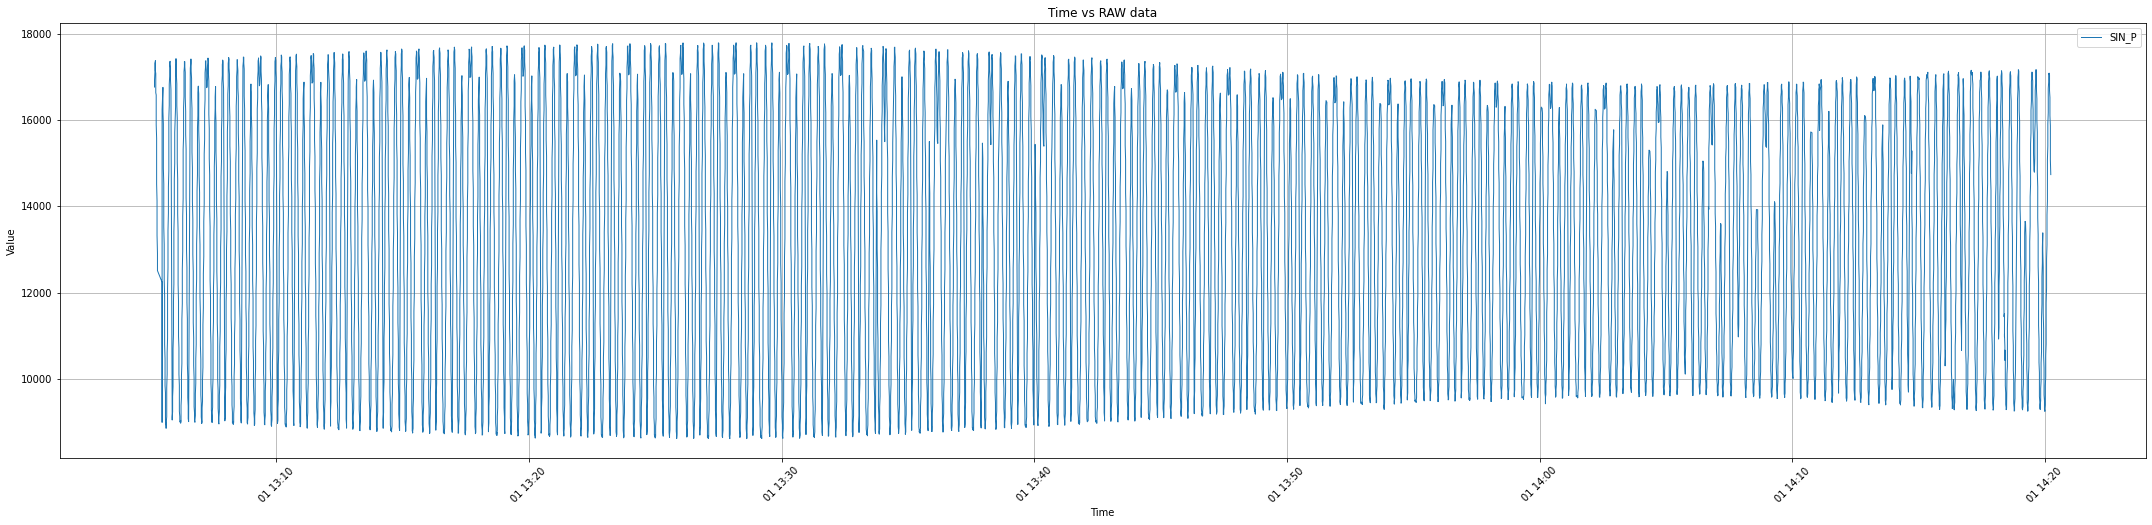

In [79]:
# Plotting SIN_P, SIN_N, COS_P, COS_N vs Time
plt.figure(figsize=(30, 7))
plt.plot(df_raw_data['timestamp'], df_raw_data['SIN_P'], label='SIN_P', linewidth=1)
# plt.plot(df_raw_data['timestamp'], df_raw_data['SIN_N'], label='SIN_N', linewidth=1)
# plt.plot(df_raw_data['timestamp'], df_raw_data['COS_P'], label='COS_P', linewidth=1)
# plt.plot(df_raw_data['timestamp'], df_raw_data['COS_N'], label='COS_N', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time vs RAW data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

# Merge Arduino and Temperature Chamber Data
This cell merges high-frequency Arduino sensor data with temperature data recorded every minute.
It interpolates temperature values to match each Arduino timestamp.

In [80]:
import re

# Convert timestamps to datetime
df_raw_data['timestamp'] = pd.to_datetime(df_raw_data['timestamp'])
df_tmp_chmber['Date/Time'] = pd.to_datetime(df_tmp_chmber['Date/Time'], format='%Y.%m.%d %H:%M:%S')

# Select and rename relevant columns
df_tmp_chmber = df_tmp_chmber.set_index('Date/Time')[['Ideal', 'Actual']]

# Create a combined dataframe
df_tmp_chmber_reset = df_tmp_chmber.reset_index().rename(columns={"Date/Time": "timestamp"})
combined_df = pd.concat([df_raw_data[['timestamp']], df_tmp_chmber_reset], axis=0, ignore_index=True)
combined_df = combined_df.sort_values('timestamp')

# Interpolate temperature data
combined_df = combined_df.set_index('timestamp')
combined_df['Ideal'] = combined_df['Ideal'].interpolate(method='time').ffill()
combined_df['Actual'] = combined_df['Actual'].interpolate(method='time').ffill()
combined_df = combined_df.reset_index()

# Filter to only Arduino timestamps
final_temp_values = combined_df[combined_df['timestamp'].isin(df_raw_data['timestamp'])].reset_index(drop=True)

# Merge with Arduino data
final_df = df_raw_data.copy()
final_df['ideal_tmp'] = final_temp_values['Ideal']
final_df['actual_tmp'] = final_temp_values['Actual']

# Extract timestamp from data file name and save the csv, to match the readings
match = re.search(r"(\d{8})_(\d{6})", raw_data_file_path)
if match:
    date_part = match.group(1)
    time_part = match.group(2)
    final_file_name = f'final_{date_part+"_"+time_part}.csv'
    print("Extracted timestamp:", date_part+"_"+time_part)
else:
    print("No timestamp found in filename.")

# Save to new CSV
final_df.to_csv(final_file_name, index=False)

final_df.head()

Extracted timestamp: 20250401_130508


,step,timestamp,encoder,SIN_P,COS_P,SIN_N,COS_N,cycle,ideal_tmp,actual_tmp
0,0,2025-04-01 13:05:11,0,16766,10981,9637,15405,1,15.080733,22.805167
1,1,2025-04-01 13:05:11,642,16925,11314,9313,14936,1,15.080733,22.805167
2,2,2025-04-01 13:05:12,614,17116,11697,9266,14688,1,14.917467,22.804083
3,3,2025-04-01 13:05:12,627,17255,12083,9135,14302,1,14.917467,22.804083
4,4,2025-04-01 13:05:12,631,17322,12460,9042,13908,1,14.917467,22.804083


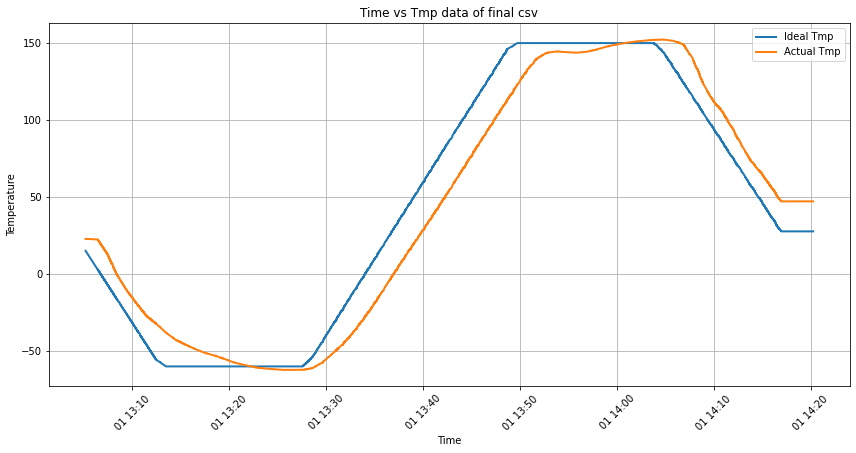

In [81]:
# Printing the temperature data from final csv
plt.figure(figsize=(12, 6))
plt.plot(final_df['timestamp'], final_df['ideal_tmp'], label='Ideal Tmp', linewidth=2)
plt.plot(final_df['timestamp'], final_df['actual_tmp'], label='Actual Tmp', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Time vs Tmp data of final csv')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

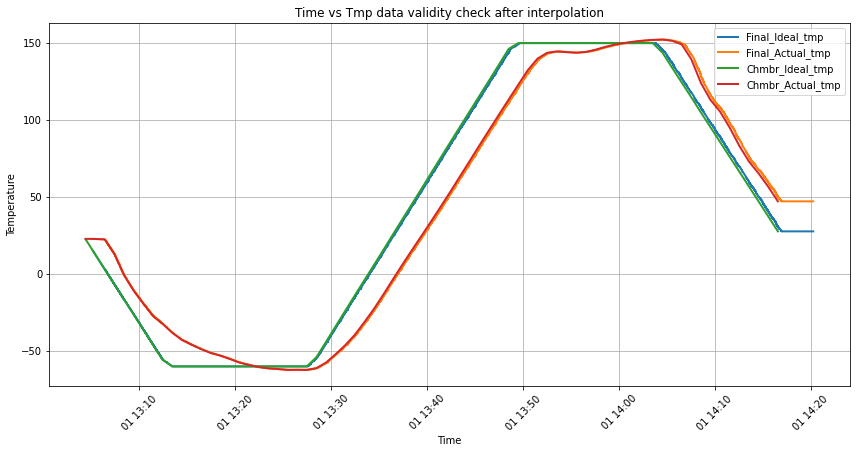

In [82]:
# Comparing the data validity after interpolation, printing graph of temp chamnber and final csv.
plt.figure(figsize=(12, 6))
plt.plot(final_df['timestamp'], final_df['ideal_tmp'], label='Final_Ideal_tmp', linewidth=2)
plt.plot(final_df['timestamp'], final_df['actual_tmp'], label='Final_Actual_tmp', linewidth=2)
plt.plot(df_tmp_chmber.index, df_tmp_chmber['Ideal'], label='Chmbr_Ideal_tmp', linewidth=2)
plt.plot(df_tmp_chmber.index, df_tmp_chmber['Actual'], label='Chmbr_Actual_tmp', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Time vs Tmp data validity check after interpolation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()